In [1]:
from typing import List, Tuple, Callable


import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import rasterio


from rasterio.crs import CRS
from rasterio.transform import from_bounds
from shapely import force_2d
from shapely.geometry import box, Point, Polygon, MultiPolygon
from scipy.spatial import cKDTree
from sklearn.gaussian_process import GaussianProcessRegressor
from pykrige.rk import Krige
from pykrige.ok import OrdinaryKriging
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Kernel


from flood_density.plots import plot_gdf, city_bounds_and_density_plot, plot_kriging_results_with_basemap
from flood_density.preprocess import convert_kml_to_gdf, export_to_geojson,get_bounds_xy_min_max, extract_bounds_polygon, polygon_to_gdf, extract_city_data, coordinates_to_box, points_geocoordinates, convert_points_in_gdf, extract_city_bounds_from_df_to_gdf, gdf_to_geojson, clip_density_to_urban_area, prepare_coords, prepare_centroids, create_kriging_kernel, create_gpr_model, interpolate_grid, predict_grid, fit_gpr_model,convert_to_2d_grid

CRS_4326 = 4326


# Etapa 1 : Obtener datos .kml de la ciudad de La Plata.

In [2]:
gdf_from_kml = convert_kml_to_gdf('laplata_cascourbano.kml')


/home/andy/.local/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'laplata_cascourbano.kml': 'La Plata' (default), 'La Plata (#2)', 'La Plata (#3)'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
gdf_peligrosidad = export_to_geojson(gdf_from_kml, 'laplata_cascourbano.geojson')

In [35]:
gdf_peligrosidad

,Name,Description,geometry
0,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.93986 -34.92733 0, -57.9..."
1,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.9475 -34.94511 0, -57.94..."
2,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.93726 -34.93996 0, -57.9..."
3,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.9535 -34.95246 0, -57.95..."
4,La Plata,descripción: <br>name: La Plata <br>descriptio...,"POLYGON Z ((-57.93649 -34.93926 0, -57.93649 -..."
5,La Plata,descripción: <br>name: La Plata <br>descriptio...,GEOMETRYCOLLECTION Z (LINESTRING Z (-57.94451 ...


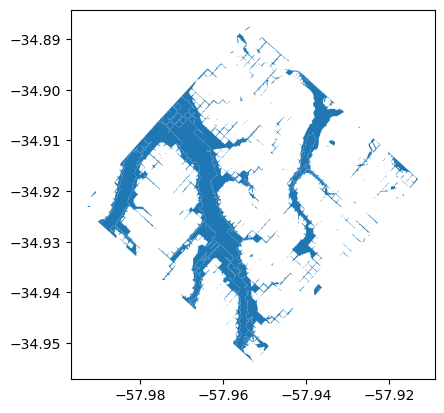

In [4]:
plot_peligrosidad = plot_gdf(gdf_peligrosidad)

# Etapa 2: Obtener las coordenadas de los puntos de la ciudad, formamos un polígono y luego, transformamos a un gdf.


In [5]:
#¿Cómo obtengo bounds_dict? son coordenadas de la ciudad de La Plata Desde el archivo geojson

In [6]:
#Extraemos las coordenadas geográficas de la ciudad 
city_bounds_coordinates= get_bounds_xy_min_max(gdf_peligrosidad)
city_bounds_coordinates

{'x_min': -57.992667,
 'y_min': -34.953843,
 'x_max': -57.91312,
 'y_max': -34.887489}

In [7]:
# Convertimos las coordenadas de la ciudad a un box
boxx = coordinates_to_box(city_bounds_coordinates)

In [8]:
#Usar el dataframe del polígono que forma las coordenadas de la LP
gdf_la_plata_from_polygon = gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:4326')

In [ ]:
# Convertir a EPSG 32721 (UTM zona 21S) --- lo uso para el plot de geotiff
#gdf_la_plata_from_polygon = gdf_la_plata_from_polygon.to_crs(epsg=32721)

# Etapa 3 : Obtener y transformar datos de densidad poblacional de la ciudad de La Plata.

Primero extraemos las filas que pertenecen a la ciudad de La Plata(sigue siendo un .csv), luego convertimos ese dataframe en un geodataframe.

In [10]:
#Levantamos el dataset completo
df_arg = pd.read_csv("arg_pd_2020_1km_ASCII_XYZ.csv") 

In [11]:
# Extraemos las filas referidas a la ciudad de La Plata
df_lp_coordinates = extract_city_data(df_arg,'la_plata',city_bounds_coordinates)
df_lp_coordinates

,X,Y,Z
2005769,-57.988750,-34.887916,4390.450195
2005770,-57.980416,-34.887916,4219.690918
2005771,-57.972083,-34.887916,3577.566895
2005772,-57.963750,-34.887916,4450.521973
2005773,-57.955416,-34.887916,3841.554199
...,...,...,...
2016355,-57.947083,-34.946250,4543.715820
2016356,-57.938750,-34.946250,4086.931885
2016357,-57.930416,-34.946250,3947.445801
2016358,-57.922083,-34.946250,3537.828613


In [12]:
#Leemos los datos específicos de la ciudad de La Plata
df_lp_coordinates = pd.read_csv('la_plata_population_2020.csv')
df_lp_coordinates


,X,Y,Z
0,-57.988750,-34.887916,4390.450195
1,-57.980416,-34.887916,4219.690918
2,-57.972083,-34.887916,3577.566895
3,-57.963750,-34.887916,4450.521973
4,-57.955416,-34.887916,3841.554199
...,...,...,...
75,-57.947083,-34.946250,4543.715820
76,-57.938750,-34.946250,4086.931885
77,-57.930416,-34.946250,3947.445801
78,-57.922083,-34.946250,3537.828613


In [13]:
#Convertir dataframe de los puntos pertenecientes a la ciudad de La Plata en un geodataframe
gdf_lp_coordinates = extract_city_bounds_from_df_to_gdf(df_lp_coordinates, 'Y','X')

In [14]:
# Extraemos las coordenadas de los puntos dentro de la ciudad de La Plata
casco_urbano = clip_density_to_urban_area(gdf_lp_coordinates,gdf_peligrosidad)

In [15]:
# Reproyectar a EPSG 32721 (UTM zona 21S)
casco_urbano_utm = casco_urbano.to_crs(epsg=32721)
casco_urbano_utm

,X,Y,Z,geometry,Name,Description
22,-57.972083,-34.904583,5416.428223,POINT (411191.477 6137107.129),La Plata,descripción: <br>name: La Plata <br>descriptio...
31,-57.980416,-34.912916,5103.672852,POINT (410439.177 6136175.537),La Plata,descripción: <br>name: La Plata <br>descriptio...
33,-57.963750,-34.912916,5795.110352,POINT (411961.724 6136190.323),La Plata,descripción: <br>name: La Plata <br>descriptio...
36,-57.938750,-34.912916,4231.409668,POINT (414245.539 6136212.026),La Plata,descripción: <br>name: La Plata <br>descriptio...
43,-57.963750,-34.921250,5794.330078,POINT (411970.623 6135266.155),La Plata,descripción: <br>name: La Plata <br>descriptio...
53,-57.963750,-34.929583,5190.817871,POINT (411979.523 6134341.986),La Plata,descripción: <br>name: La Plata <br>descriptio...
54,-57.955416,-34.929583,5635.426758,POINT (412740.641 6134349.285),La Plata,descripción: <br>name: La Plata <br>descriptio...
56,-57.938750,-34.929583,5082.848633,POINT (414262.876 6134363.694),La Plata,descripción: <br>name: La Plata <br>descriptio...
64,-57.955416,-34.937916,5090.878418,POINT (412749.467 6133425.116),La Plata,descripción: <br>name: La Plata <br>descriptio...
74,-57.955416,-34.946250,4224.697266,POINT (412758.294 6132500.945),La Plata,descripción: <br>name: La Plata <br>descriptio...


In [16]:
# Calcular centroides en el CRS proyectado
centroides = casco_urbano_utm.geometry.centroid

In [17]:
# Convertir centroides a un array de coordenadas
coords_centroides = np.array([[pt.x, pt.y] for pt in centroides])

In [18]:
# Extraer densidades de casco_urbano_utm
values_density_lp = casco_urbano_utm['Z'].values

In [19]:
#Extraer los límites del polígono de la ciudad de La Plata
bounds_lp = gdf_la_plata_from_polygon.total_bounds  # [minx, miny, maxx, maxy]
bounds_lp

array([ 409292.09738085, 6131625.70628701,  416628.30365384,
       6139053.5533489 ])

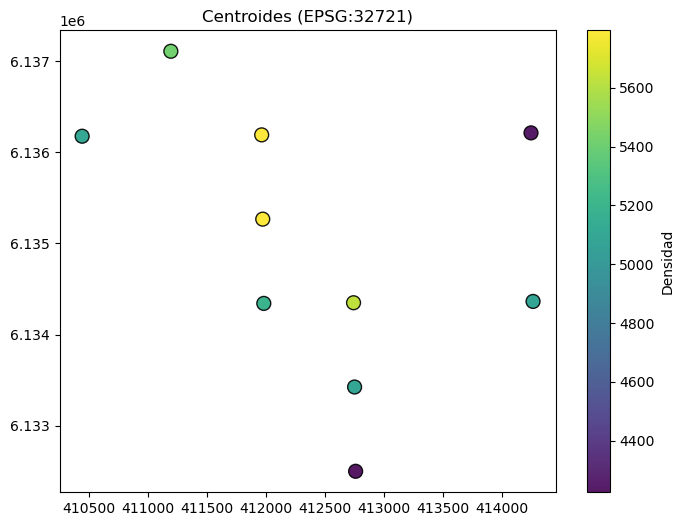

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(coords_centroides[:, 0], coords_centroides[:, 1],
                c=values_density_lp, s=100,
                cmap='viridis', alpha=0.9,
                edgecolor='black', linewidth=1,
                marker='o')

plt.colorbar(sc, ax=ax, label='Densidad')
ax.set_title("Centroides (EPSG:32721)")
plt.show()

# Etapa 4 : Merge polígono y zona de densidad de la ciudad de La Plata en un plot para corroborar consistencia geográfica.

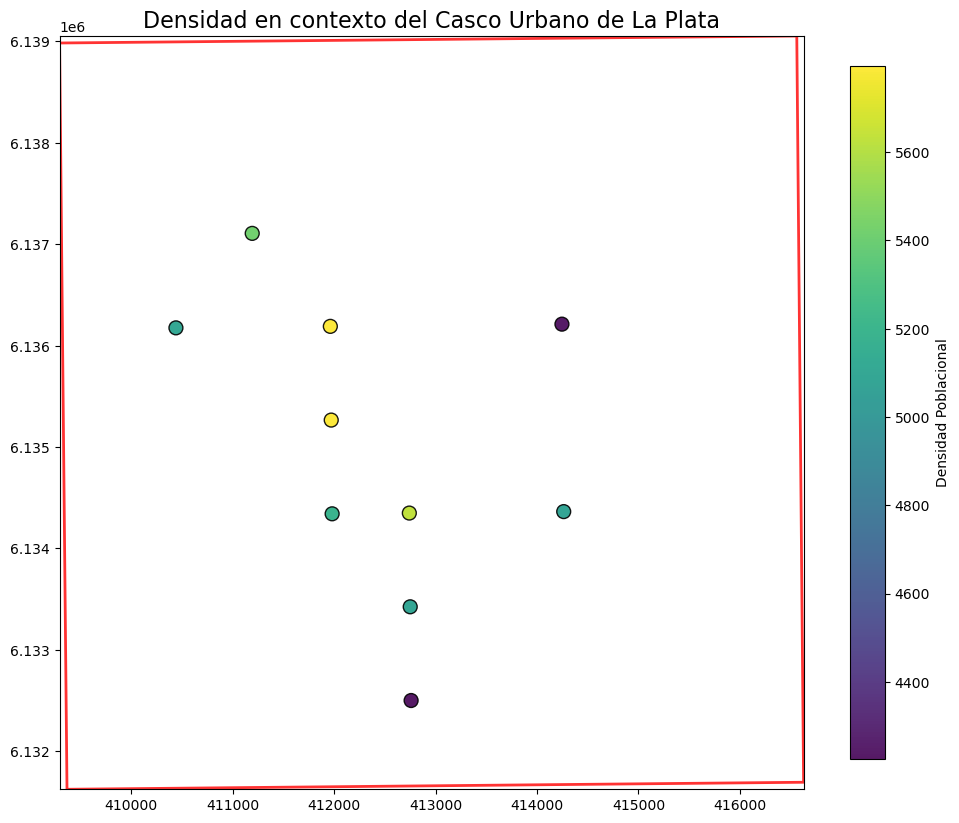

In [21]:
city_bounds_and_density_plot(gdf_la_plata_from_polygon, coords_centroides, values_density_lp, bounds_lp)

# Etapa 5 :  Visualización de la densidad poblacional de La Plata usando kriging.

In [22]:
casco_urbano_utm

,X,Y,Z,geometry,Name,Description
22,-57.972083,-34.904583,5416.428223,POINT (411191.477 6137107.129),La Plata,descripción: <br>name: La Plata <br>descriptio...
31,-57.980416,-34.912916,5103.672852,POINT (410439.177 6136175.537),La Plata,descripción: <br>name: La Plata <br>descriptio...
33,-57.963750,-34.912916,5795.110352,POINT (411961.724 6136190.323),La Plata,descripción: <br>name: La Plata <br>descriptio...
36,-57.938750,-34.912916,4231.409668,POINT (414245.539 6136212.026),La Plata,descripción: <br>name: La Plata <br>descriptio...
43,-57.963750,-34.921250,5794.330078,POINT (411970.623 6135266.155),La Plata,descripción: <br>name: La Plata <br>descriptio...
53,-57.963750,-34.929583,5190.817871,POINT (411979.523 6134341.986),La Plata,descripción: <br>name: La Plata <br>descriptio...
54,-57.955416,-34.929583,5635.426758,POINT (412740.641 6134349.285),La Plata,descripción: <br>name: La Plata <br>descriptio...
56,-57.938750,-34.929583,5082.848633,POINT (414262.876 6134363.694),La Plata,descripción: <br>name: La Plata <br>descriptio...
64,-57.955416,-34.937916,5090.878418,POINT (412749.467 6133425.116),La Plata,descripción: <br>name: La Plata <br>descriptio...
74,-57.955416,-34.946250,4224.697266,POINT (412758.294 6132500.945),La Plata,descripción: <br>name: La Plata <br>descriptio...


## 1. Preparar los datos (coordenadas y centroides)

In [23]:
centroids_lp = prepare_centroids(casco_urbano_utm, 'Z')

Rango de valores: 4224.70 - 5795.11


In [24]:
coordinates_lp = prepare_coords(casco_urbano_utm)

## 2. Ajustar modelo kriging

In [25]:
kernel = create_kriging_kernel(constant_value=1.0, length_scale=1000.0, noise_level=0.1,length_scale_bounds= (1e-2, 1e3), noise_level_bounds=(1e-10, 1e3))

## 3. Generar el modelo GaussianProcessRegressor


In [26]:
gpr_model_kriging = create_gpr_model(kernel)

In [27]:
gpr_kriging_fit = fit_gpr_model(gpr_model_kriging, coordinates_lp, centroids_lp)

/home/andy/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/andy/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## 4. Crear malla para interpolar


In [28]:
grid_x, grid_y, grid_coords = interpolate_grid(bounds_lp, step=100)

## 5. Predecir en la malla


In [29]:
predict_grid_lp = predict_grid(gpr_kriging_fit, (grid_x, grid_y, grid_coords))

## 6. Convertir resultados a grillas 2D


In [30]:
grid_2d_lp = convert_to_2d_grid(predict_grid_lp, grid_x.shape)

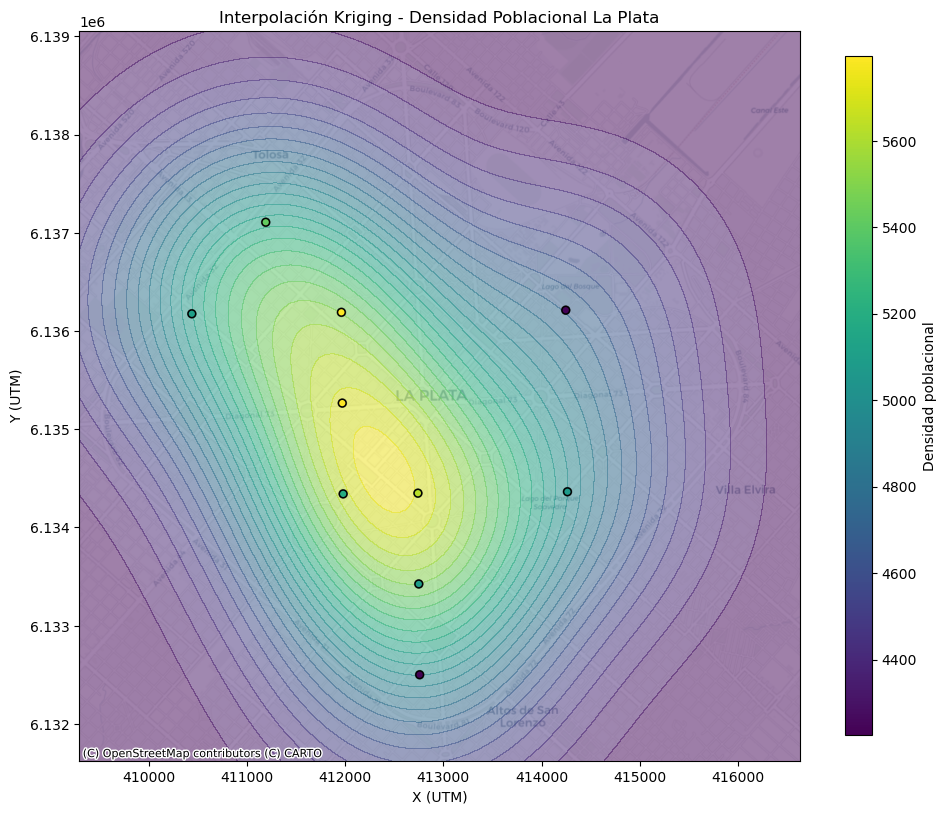

In [31]:
plot_kriging_results_with_basemap(casco_urbano_utm, coordinates_lp, centroids_lp, bounds_lp, grid_x, grid_y, gpr_kriging_fit, grid_2d_lp)

# Etapa 6 : Exportar plot a GeoTIFF

## 1. Extraer grilla de datos

In [37]:
def extract_grid_from_tuple(grid_data: Tuple[np.ndarray, ...]) -> np.ndarray:
    
    grid_array = grid_data[0]
    
    return grid_array.shape

---------------------------------

In [ ]:
#Exportar una grilla de datos a formato GeoTIFF desde una tupla
#def export_to_geotiff(grid_data: Tuple[np.ndarray], 
#                     gdf: gpd.GeoDataFrame,
#                     gdf_2: gpd.GeoDataFrame,
#                     filename: str,
#                     crs_epsg: int = 32721):
#    
#    # Extraer el primer elemento (la grilla de datos)
#    grid_array = grid_data[0]
#
#    # Convertir las coordenadas del polígono a un objeto de caja
#    boxx = coordinates_to_box(city_bounds_coordinates)
#
#    #city_bounds_coordinates= get_bounds_xy_min_max(gdf)
#
#    #def get_bounds_xy_min_max(gdf: gpd.GeoDataFrame) -> Dict[str,float]:
#    ## Extraer límites
#    #minx, miny, maxx, maxy = gdf.total_bounds
#    #return {
#    #    "x_min": minx,
#    #    "y_min": miny,
#    #    "x_max": maxx,
#    #    "y_max": maxy
#    #}
#
#
#
#    # Usar el dataframe del polígono que forma las coordenadas de  La Plata (EOPSG:4326)
#    gdf_2= gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:4326')
#
#    # Transformar al CRS del plot (EPSG:32721)
#    gdf_2 = gdf_2.to_crs(epsg=32721)
#
#    # Obtener límites en coordenadas proyectadas
#    bounds_proj = gdf_2.total_bounds  # [xmin, ymin, xmax, ymax]
#    height, width = grid_array.shape
#    
#    # Calcula la transformación georreferenciada
#    transform = from_bounds(bounds_proj[0], bounds_proj[1], bounds_proj[2], bounds_proj[3], width, height)
#    
#    with rasterio.open(
#        filename,
#        'w',
#        driver='GTiff',
#        height=height,
#        width=width,
#        count=1,
#        dtype=grid_array.dtype,
#        crs=CRS.from_epsg(crs_epsg),
#        transform=transform,
#        compress='lzw'
#    ) as dst:
#        dst.write(grid_array, 1)
#        dst.set_band_description(1, 'Densidad Poblacional Kriging')

In [ ]:
# 5. Pipeline principal
#def run_kriging_pipeline(geodf, value_column, bounds, step=100):
#    coords, values = prepare_data(geodf, value_column)
#    model = fit_kriging(coords, values)
#    grid_xx, grid_yy, z = interpolate_grid(model, bounds, step)
#    plot_kriging_results(grid_xx, grid_yy, z, coords, values, bounds)

In [ ]:
# Exportar superficie interpolada
export_to_geotiff(grid_2d_lp, gdf_peligrosidad, gdf_la_plata_from_polygon, 'Densidad Poblacional Kriging', 32721)